# Gaussian Classifiers for Digits and Spam

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pylab as plb
from numpy import corrcoef, sum, log, arange
from scipy.stats import multivariate_normal

# Read data

In [2]:
mnist = sio.loadmat('hw3_mnist_dist/train.mat')
mnist = mnist['trainX']
np.random.shuffle(mnist)

In [3]:
 # mnist train set
mnist_train = mnist[...,range(mnist.shape[1]-1)]
train_label = mnist[...,-1]

In [4]:
def fit_normal(X,y,digit):
    X = X[y==digit]
    mean = np.mean(X,0)
    cov_mat = np.cov(X,rowvar= False)
    return {'mean' :mean,
            'cov_mat' : cov_mat}

def normalize_mnist(x,y): 
    norm = np.apply_along_axis(np.linalg.norm, 1, x)
    new = x/np.repeat(norm.reshape(-1,1),x.shape[1],axis=1)
    y = y.T.reshape(y.shape[0],1)
    return np.hstack((new,y))
mnist_new = normalize_mnist(mnist_train,train_label)

In [6]:
all_digit = dict()
cov = [[0 for i in range(784)] for j in range(784)]
cov = np.array(cov)
for i in range(10):
    digit_x = fit_normal(mnist_new[...,range(mnist_new.shape[1]-1)],mnist_new[...,-1],i)
    cov = cov + digit_x['cov_mat']
    cov = cov/10
    all_digit.update({'Digit: {}'.format(i):digit_x})
#print(all_digit)

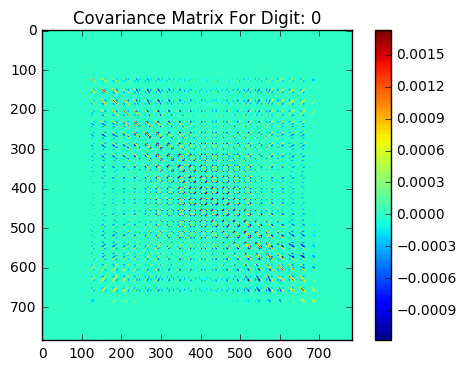

In [41]:
def plot_cov_mat(X,y,digit,title):
    digit_x = fit_normal(X,y,digit)
    #plb.figure(figsize = (4,4))
    plb.imshow(digit_x['cov_mat'])
    plb.title('Covariance Matrix For Digit: {}'.format(digit))
    plb.colorbar()
    plb.savefig(title)
    plb.show()
    
plot_cov_mat(mnist_new[...,range(mnist_new.shape[1]-1)],mnist_new[...,-1],0,'cov_matix.png')

# LDA

In [7]:

X = mnist_new[...,range(mnist_new.shape[1]-1)]
y = mnist_new[...,-1]

X_train = X[:50000,]
X_val = X[50000:,]
y_train = y[:50000,]
y_val = y[50000:,]

In [8]:
# count prior
label = y.tolist()
for i in set(label):
    c = label.count(i)
    print((i,c/len(label)))
priors = [(i,label.count(i)/len(label)) for i in set(label)]
n,p = zip(*priors)

(0.0, 0.09871666666666666)
(1.0, 0.11236666666666667)
(2.0, 0.0993)
(3.0, 0.10218333333333333)
(4.0, 0.09736666666666667)
(5.0, 0.09035)
(6.0, 0.09863333333333334)
(7.0, 0.10441666666666667)
(8.0, 0.09751666666666667)
(9.0, 0.09915)


In [9]:
def get_mu(X,y,alpha):
    mu = []
    for i in np.arange(10):
        digit_x = fit_normal(X,y,i)
        mu.append(digit_x['mean'])
    return np.array(mu)

def get_sigma_LDA(X,y,alpha):
    cov = [[0 for i in range(784)] for j in range(784)]
    cov = np.array(cov)
    for i in range(10):
        digit_x = fit_normal(X,y,i)
        cov = cov + digit_x['cov_mat']
        cov = cov/10
    cov = cov + np.diag(np.repeat(alpha,cov.shape[0]))
    return cov


def predict_LDA(X, mu, cov,alpha):
    pred = []
    for i in np.arange(10):
        fit_multi  = multivariate_normal(mean=mu[i], cov=cov)
        pred.append(fit_multi.logpdf(X)+np.log(p[i]))
    y_pred = np.argmax(np.array(pred), axis=0)
    return y_pred

def LDA(X_train,y_train,X_val,y_val,sample_size,alpha):
    error_rate = []
    for i in sample_size:
        mu = get_mu(X_train[:i,],y_train[:i],alpha)
        Sigma = get_sigma_LDA(X_train[:i,],y_train[:i],alpha)
        y_pred = predict_LDA(X_val,mu,Sigma,alpha)
        accuracy = np.sum(y_val == y_pred)/y_val.shape[0]
        error = 1 - accuracy
        error_rate.append((i,error))
    return error_rate

In [16]:
sample_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
error_LDA = LDA(X_train,y_train,X_val,y_val,sample_sizes,pow(10,-3))

In [17]:
error_LDA

[(100, 0.28139999999999998),
 (200, 0.22250000000000003),
 (500, 0.20009999999999994),
 (1000, 0.18320000000000003),
 (2000, 0.1774),
 (5000, 0.17100000000000004),
 (10000, 0.1704),
 (30000, 0.16739999999999999),
 (50000, 0.16779999999999995)]

In [22]:
for x in error_LDA:
    print("Sample size is %d" %x[0], "; LDA training error is %f" %x[1])

Sample size is 100 ; LDA training error is 0.281400
Sample size is 200 ; LDA training error is 0.222500
Sample size is 500 ; LDA training error is 0.200100
Sample size is 1000 ; LDA training error is 0.183200
Sample size is 2000 ; LDA training error is 0.177400
Sample size is 5000 ; LDA training error is 0.171000
Sample size is 10000 ; LDA training error is 0.170400
Sample size is 30000 ; LDA training error is 0.167400
Sample size is 50000 ; LDA training error is 0.167800


# QDA

In [10]:
def fit_normal_QDA(X,y,digit,alpha):
    X = X[y==digit]
    mean = np.mean(X,0)
    cov_mat = np.cov(X,rowvar= False)
    cov_mat = cov_mat + np.diag(np.repeat(alpha,cov_mat.shape[0]))
    return {'mean' :mean,
            'cov_mat' : cov_mat}

def get_mu_QDA(X,y,alpha):
    mu = []
    for i in np.arange(10):
        digit_x = fit_normal_QDA(X,y,i,alpha)
        mu.append(digit_x['mean'])
    return np.array(mu)

def get_sigma_QDA(X,y,alpha):
    Sigma = []
    for i in np.arange(10):
        digit_x = fit_normal_QDA(X,y,i,alpha)
        Sigma.append(digit_x['cov_mat'])
    return np.array(Sigma)

def predict_QDA(X, mu, cov):
    pred = []
    for i in np.arange(10):
        fit_multi  = multivariate_normal(mean=mu[i], cov=cov[i])#*
        pred.append(fit_multi.logpdf(X))
    y_pred = np.argmax(np.array(pred), axis=0)
    return y_pred

def QDA_alpha(X_train,y_train,X_val,y_val,alpha):
    error_rate = []
    for i in alpha:
        mu = get_mu_QDA(X_train,y_train,i)
        Sigma = get_sigma_QDA(X_train,y_train,i)
        y_pred = predict_QDA(X_val,mu,Sigma)
        accuracy = np.sum(y_val == y_pred)/y_val.shape[0]
        error = 1 - accuracy
        error_rate.append(error)
    return error_rate

def QDA(X_train,y_train,X_val,y_val,sample_size,alpha):
    error_rate = []
    for i in sample_size:
        mu = get_mu(X_train[:i,],y_train[:i],alpha)
        Sigma = get_sigma_QDA(X_train[:i,],y_train[:i],alpha)
        y_pred = predict_QDA(X_val,mu,Sigma)
        accuracy = np.sum(y_val == y_pred)/y_val.shape[0]
        error = 1 - accuracy
        error_rate.append((i,error))
    return error_rate

def train_test(X,y,test,alpha):
    mu = get_mu_QDA(X,y,alpha)
    Sigma = get_sigma_QDA(X,y,alpha)
    y_pred = predict_QDA(test,mu,Sigma)
    return y_pred

In [11]:
alpha_scale = [pow(10,-i) for i in range(1,6)]
mnist_alpha_error = QDA_alpha(X_train[:5000,],y_train[:5000,],X_val[:5000,],y_val[:5000,],alpha=alpha_scale)
best_alpha = alpha_scale[mnist_alpha_error.index(min(mnist_alpha_error))]

In [12]:
mnist_alpha_error

[0.17100000000000004,
 0.076999999999999957,
 0.047399999999999998,
 0.057400000000000007,
 0.086400000000000032]

In [13]:
best_alpha

0.001

In [14]:
sample_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
error_QDA = QDA(X_train,y_train,X_val,y_val,sample_sizes,alpha=best_alpha)

In [10]:
error_QDA

[(100, 0.26829999999999998),
 (200, 0.15769999999999995),
 (500, 0.10850000000000004),
 (1000, 0.073599999999999999),
 (2000, 0.060100000000000042),
 (5000, 0.050799999999999956),
 (10000, 0.046200000000000019),
 (30000, 0.044200000000000017),
 (50000, 0.044300000000000006)]

In [21]:
for x in error_QDA:
    print("Sample size is %d" %x[0], "; QDA training error is %f" %x[1])

Sample size is 100 ; QDA training error is 0.268300
Sample size is 200 ; QDA training error is 0.157700
Sample size is 500 ; QDA training error is 0.108500
Sample size is 1000 ; QDA training error is 0.073600
Sample size is 2000 ; QDA training error is 0.060100
Sample size is 5000 ; QDA training error is 0.050800
Sample size is 10000 ; QDA training error is 0.046200
Sample size is 30000 ; QDA training error is 0.044200
Sample size is 50000 ; QDA training error is 0.044300


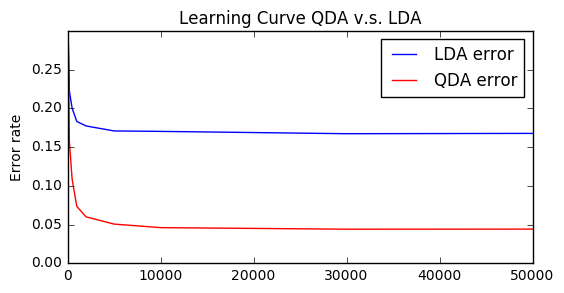

In [20]:
_,QDA_error = zip(*error_QDA)
_,LDA_error = zip(*error_LDA)

plt.figure(figsize = (6,3))
plt.plot(sample_sizes,LDA_error,label = 'LDA error',color= 'blue')
plt.plot(sample_sizes,QDA_error,label = 'QDA error',color= 'red')
plt.ylim(0,0.3)
plt.ylabel('Error rate')
plt.title('Learning Curve QDA v.s. LDA')
plt.legend(loc=1)
plt.savefig('Learining_Curve.png')
plt.show()


# Train and Test for Mnist

In [314]:
test = sio.loadmat('hw3_mnist_dist/test.mat')
test = test['testX']

In [315]:
test_norm = normalize(test)

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [ ]:
def normalize(x,y): 
    norm = np.apply_along_axis(np.linalg.norm, 1, x)
    new = x/np.repeat(norm.reshape(-1,1),x.shape[1],axis=1)
    y = y.T.reshape(y.shape[0],1)
    return np.hstack((new,y))
mnist_new = normalize(mnist_train,train_label)

In [57]:
norm = np.apply_along_axis(np.linalg.norm, 1, test)
new_test = test/np.repeat(norm.reshape(-1,1),test.shape[1],axis=1)

In [319]:
y_pred = train_test(X,y,test_norm,alpha = 0.001)

In [321]:
np.savetxt('pred_digit2.csv',y_pred,delimiter=',')

# Spam Filtering

In [43]:
import numpy as np
import pandas as pd

import scipy.io as sio
import matplotlib.pyplot as plt
import pylab as plb
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import os
import glob
import codecs as cs

In [44]:
def review_to_words(raw_data):
    review_text = BeautifulSoup(raw_data).get_text()
    letters_only = re.sub('^[a-zA-Z]',' ',review_text)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    remove_stops = [w for w in words if w not in stops]
    lmtzr = WordNetLemmatizer()
    lemma_words = [lmtzr.lemmatize(i) for i in words]
    return (" ".join(lemma_words))

def data_prepare(series):
    
    print("Cleaning and parsing the training set movie reviews...\n")
    clean_data = []
    for i in range(series.size):
          if( (i+1)%1000 == 0):
              print("Review %d of %d\n" %(i+1,series.size))
          clean_data.append(review_to_words(series[i]))
    return clean_data



In [97]:
def fit_normal_spam(X,y,label,alpha):
    X = X[y==label]
    mean = np.mean(X,0)
    cov_mat = np.cov(X,rowvar= False)
    cov_mat = cov_mat + np.diag(np.repeat(alpha,cov_mat.shape[0]))
    return {'mean' :mean,
            'cov_mat' : cov_mat}

def get_mu_spam(X,y,alpha):
    mu = []
    for i in np.arange(2):
        digit_x = fit_normal_spam(X,y,i,alpha)
        mu.append(digit_x['mean'])
    return np.array(mu)

def get_sigma_spam(X,y,alpha):
    Sigma = []
    for i in np.arange(2):
        digit_x = fit_normal_spam(X,y,i,alpha)
        Sigma.append(digit_x['cov_mat'])
    return np.array(Sigma)

def predict_spam(X, mu, cov):
    pred = []
    for i in np.arange(2):
        fit_multi  = multivariate_normal(mean=mu[i], cov=cov[i])
        pred.append(fit_multi.logpdf(X))
    y_pred = np.argmax(np.array(pred), axis=0)
    return y_pred

def spam_alpha(X_train,y_train,X_val,y_val,alpha):
    error_rate = []
    for i in alpha:
        mu = get_mu_spam(X_train,y_train,i)
        Sigma = get_sigma_spam(X_train,y_train,i)
        y_pred = predict_spam(X_val,mu,Sigma)
        accuracy = np.sum(y_val == y_pred)/y_val.shape[0]
        error = 1 - accuracy
        error_rate.append(error)
    return error_rate

def spam_QDA(X_train,y_train,X_val,y_val,sample_size,alpha):
    error_rate = []
    for i in sample_size:
        mu = get_mu_spam(X_train[:i,],y_train[:i],alpha)
        Sigma = get_sigma_spam(X_train[:i,],y_train[:i],alpha)
        y_pred = predict_spam(X_val,mu,Sigma)
        accuracy = np.sum(y_val == y_pred)/y_val.shape[0]
        error = 1 - accuracy
        error_rate.append((i,error))
    return error_rate

def train_test_spam(X,y,test,alpha):
    mu = get_mu_spam(X,y,alpha)
    Sigma = get_sigma_spam(X,y,alpha)
    y_pred = predict_spam(test,mu,Sigma)
    return y_pred

In [46]:
spamlist = os.listdir('hw3_spam_dist/spam/.')
hamlist = os.listdir('hw3_spam_dist/ham/.')

# Feature engineering

In [47]:
allspamword = []
for i in spamlist:
    
    word = []
    with cs.open('hw3_spam_dist/spam/'+i, 'r',encoding='utf-8', errors='ignore') as f:
        try:
            data = f.readlines()
            for line in data:
                word.append(line)
        except:
            pass
        
    allspamword.append(''.join(word).replace("\n",""))

allhamword = []
for i in hamlist:
    
    word = []
    with cs.open('hw3_spam_dist/ham/'+i, 'r',encoding='utf-8', errors='ignore') as f:
        try:
            data = f.readlines()
            for line in data:
                word.append(line)
        except:
            pass
        
    allhamword.append(''.join(word).replace("\n",""))    

In [48]:
spam = data_prepare(pd.Series(allspamword))

Cleaning and parsing the training set movie reviews...



//anaconda/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file //anaconda/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Review 1000 of 12015

Review 2000 of 12015

Review 3000 of 12015

Review 4000 of 12015

Review 5000 of 12015

Review 6000 of 12015

Review 7000 of 12015

Review 8000 of 12015

Review 9000 of 12015

Review 10000 of 12015

Review 11000 of 12015

Review 12000 of 12015



In [49]:
ham = data_prepare(pd.Series(allhamword))

Cleaning and parsing the training set movie reviews...



//anaconda/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file //anaconda/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Review 1000 of 11687

Review 2000 of 11687

Review 3000 of 11687

Review 4000 of 11687

Review 5000 of 11687

Review 6000 of 11687

Review 7000 of 11687

Review 8000 of 11687

Review 9000 of 11687

Review 10000 of 11687

Review 11000 of 11687



In [50]:
#spam and ham
spam_ham = spam + ham
vectorizer = CountVectorizer(max_features = 1000)
spam_ham_vec = vectorizer.fit_transform(spam_ham)
spam_ham_vec = spam_ham_vec.toarray()
voc = np.asarray(vectorizer.get_feature_names())
# label
spam_label = np.repeat(1,len(spam),axis=0).reshape(-1,1)
ham_label = np.repeat(0,len(ham),axis=0).reshape(-1,1)
label = np.vstack([spam_label, ham_label])
# new train data
X_new = normalize(spam_ham_vec)
train = np.hstack([X_new,label])
np.random.shuffle(train)

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [51]:
# split into train set and validation set
X = train[...,range(train.shape[1]-1)]
y = train[...,-1]
X_train = X[:18000,]
X_val = X[18000:,]
y_train = y[:18000,]
y_val = y[18000:,]

In [98]:
alpha_scale = [pow(10,-i) for i in range(4,11)]
spam_alpha_error = spam_alpha(X_train,y_train,X_val,y_val,alpha=alpha_scale)
best_alpha = alpha_scale[spam_alpha_error.index(min(spam_alpha_error))]

In [99]:
spam_alpha_error 

[0.028060329708874066,
 0.027008067344791331,
 0.027008067344791331,
 0.027358821466152206,
 0.027358821466152206,
 0.026657313223430346,
 0.027008067344791331]

In [100]:
best_alpha

1e-09

In [71]:
sample_sizes = [100, 200, 500, 1000, 2000, 5000, 10000]
spam_error_QDA1 = spam_QDA(X_train,y_train,X_val,y_val,sample_sizes,alpha=best_alpha)

In [301]:
spam_error_QDA

[(100, 0.1099614170466503),
 (200, 0.089442300947036091),
 (500, 0.054366888810943537),
 (1000, 0.041388986320589294),
 (2000, 0.033146264468607467),
 (5000, 0.029287969133637293),
 (10000, 0.028411083830235051)]

In [73]:
y_pred = train_test_spam(X_train, y_train,X_val,best_alpha)
confusion_matrix(y_val,y_pred)

array([[2693,   89],
       [  63, 2857]])

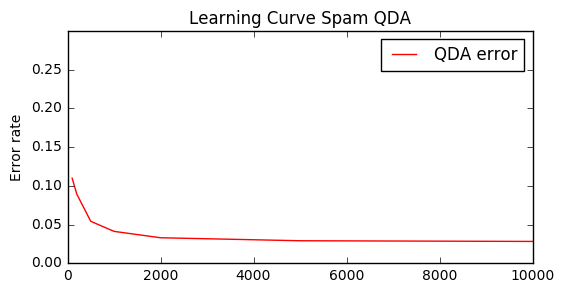

In [304]:
_,QDA_error = zip(*spam_error_QDA)

plt.figure(figsize = (6,3))
#plt.plot(sample_sizes,LDA_error,label = 'LDA error',color= 'blue')
plt.plot(sample_sizes,QDA_error,label = 'QDA error',color= 'red')
plt.ylim(0,0.3)
plt.ylabel('Error rate')
plt.title('Learning Curve Spam QDA')
plt.legend(loc=1)
plt.show()



# Predict test data

In [75]:
BASE_DIR = './'
TEST_DIR = 'test/'
NUM_TEST_EXAMPLES = 10000
testlist = [ str(x) + '.txt' for x in range(NUM_TEST_EXAMPLES)]

test = []
for i in testlist:
    
    word = []
    with cs.open('hw3_spam_dist/test/'+i, 'r',encoding='utf-8', errors='ignore') as f:
        try:
            data = f.readlines()
            for line in data:
                word.append(line)
        except:
            pass
    
    test.append(''.join(word).replace("\n",""))

In [76]:
test = data_prepare(pd.Series(test))

Cleaning and parsing the training set movie reviews...



//anaconda/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file //anaconda/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Review 1000 of 10000

Review 2000 of 10000

Review 3000 of 10000

Review 4000 of 10000

Review 5000 of 10000

Review 6000 of 10000

Review 7000 of 10000

Review 8000 of 10000

Review 9000 of 10000

Review 10000 of 10000



In [77]:
#test data
new_vect = CountVectorizer(vocabulary=voc)
test_spam = new_vect.fit_transform(test)
test_spam = test_spam.toarray()

test_norm = normalize(test_spam)

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [78]:
result = train_test_spam(X,y,test_norm,best_alpha)

In [286]:
np.savetxt('pred_spam_2.csv',result,delimiter=',')